##BreastCancer_IDC_Grade

## Objectives
- Fusion of CNN Features and Ensemble Classifiers for Diagnosis of Skin Diseases in Dermoscopic Images
- Four key components of any ML system (in PyTorch):
 - Data (Images)
 - Model (Ensemble : CNN + LR, SVC, DTC, KNN, RF)
 - Loss (Cross Entropy)
 - Optimization (SGD)
- Convolutional Neural Networks (CNNs)
- Transfer learning
-Voting Five Classifier For Ensemble Classification (LR, SVC, DTC, KNN, RF)
-Data Preprocessing
  - Data augmentation
  - Skin lesion segmentation
  - Remove Hair
-Visualization Feature Map


In [ ]:
!pip install torch
!pip install torchvision

In [ ]:
!pip install scikit-plot

In [ ]:
!pip install opencv-python

#Import Library

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import itertools
from sklearn.metrics import confusion_matrix
import cv2
from sklearn.model_selection import cross_val_score
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import scikitplot as skplt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

#Connect Google Drive

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

!ls 'drive/My Drive'

# Data

In [ ]:
DATA_DIR = '/content/drive/MyDrive/Project/BreastCancer/Dataset/Dataset'
trn_dir = '/content/drive/MyDrive/Project/BreastCancer/Dataset/Dataset/data'

sz = 224
batch_size = 32
os.listdir(trn_dir)

In [ ]:
BreastCancer_IDC_Grade1='/content/drive/MyDrive/BreastCancer/Dataset/1'
BreastCancer_IDC_Grade1 = sorted(next(os.walk(BreastCancer_IDC_Grade1))[2])
BreastCancer_IDC_Grade1=len(BreastCancer_IDC_Grade1)
BreastCancer_IDC_Grade2='/content/drive/MyDrive/BreastCancer/Dataset/2'
BreastCancer_IDC_Grade2 = sorted(next(os.walk(BreastCancer_IDC_Grade2))[2])
BreastCancer_IDC_Grade2=len(BreastCancer_IDC_Grade2)
BreastCancer_IDC_Grade3='/content/drive/MyDrive/BreastCancer/Dataset/3'
BreastCancer_IDC_Grade3 = sorted(next(os.walk(BreastCancer_IDC_Grade3))[2])
BreastCancer_IDC_Grade3=len(BreastCancer_IDC_Grade3)
SUM_DATA = int(BreastCancer_IDC_Grade1+BreastCancer_IDC_Grade2+BreastCancer_IDC_Grade3)

my_dict = {
    'Targets': ["BreastCancer_IDC_Grade1", "BreastCancer_IDC_Grade2", "BreastCancer_IDC_Grade3"],
    'Count': [BreastCancer_IDC_Grade1, BreastCancer_IDC_Grade2, BreastCancer_IDC_Grade3]

}
print('Total Dataset Images:', SUM_DATA)
df = pd.DataFrame(my_dict, index=[1,2,3])
df.tail(3)


Total Dataset Images: 454


,Targets,Count
1,BreastCancer_IDC_Grade1,131
2,BreastCancer_IDC_Grade2,180
3,BreastCancer_IDC_Grade3,143


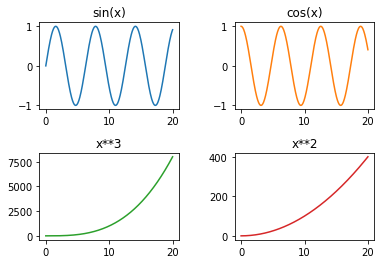

In [ ]:
fig, axs = plt.subplots(2, 2 ,gridspec_kw={'hspace': 0.5, 'wspace': 0.4})
x = np.linspace(0, 20, 400)
y = np.sin(x)
z=np.cos(x)
m = (x**3)
n=(x**2)
axs[0, 0].plot(x, y)
axs[0, 0].set_title('sin(x)')
axs[0, 1].plot(x, z, 'tab:orange')
axs[0, 1].set_title('cos(x)')
axs[1, 0].plot(x, m, 'tab:green')
axs[1, 0].set_title('x**3')
axs[1, 1].plot(x,n, 'tab:red')
axs[1, 1].set_title('x**2')
plt.show()

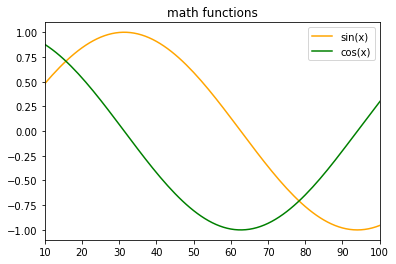

In [ ]:
import numpy as np
plt.plot(np.sin(x),label='sin(x)',color='orange')
plt.plot(np.cos(x),label='cos(x)',color='green')
plt.xlim(10,100)
plt.legend()
plt.title('math functions')
plt.show()

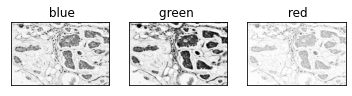

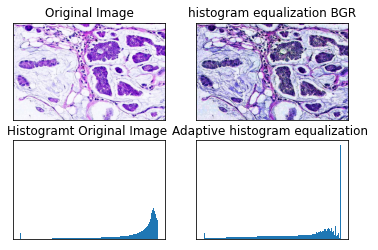

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version,

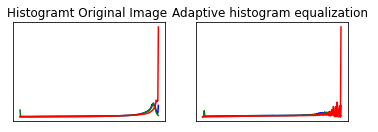

In [ ]:
image4 = mpimg.imread('/content/drive/MyDrive/BreastCancer/Dataset/tr/b/bb/0.1_268_2_2.jpg')
clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))
(b,g,r) = cv2.split(image4)
#plt.subplot(221), plt.imshow(image4) #, plt.title('Original Image')
#plt.title('Original Image'), plt.xticks([]), plt.yticks([])
#plt.show()

plt.subplot(131), plt.imshow(b, cmap='gray') #, plt.title('blue')
plt.title(' blue'), plt.xticks([]), plt.yticks([])
#plt.show()
plt.subplot(132), plt.imshow(g, cmap='gray') #, plt.title('green')
plt.title('green '), plt.xticks([]), plt.yticks([])
#plt.show()
plt.subplot(133), plt.imshow(r, cmap='gray')#, plt.title('red')
plt.title(' red'), plt.xticks([]), plt.yticks([])
plt.show()
b1 = clahe.apply(b)
g1 = clahe.apply(g)
r1 = clahe.apply(r)
mrg = cv2.merge((b1,g1,r1))  # merge channels
plt.subplot(221), plt.imshow(image4) #, plt.title('Original Image')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(mrg)#, plt.title('mrg')
plt.title('histogram equalization BGR'), plt.xticks([]), plt.yticks([])
#plt.show()
plt.subplot(223), plt.hist(image4.ravel(),256,[0,256])
plt.title('Histogramt Original Image '), plt.xticks([]), plt.yticks([])
#plt.show()
plt.subplot(224), plt.hist(mrg.ravel(),256,[0,256])
plt.title('Adaptive histogram equalization '), plt.xticks([]), plt.yticks([])
plt.show()
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([image4],[i],None,[256],[0,256])
    histr1 = cv2.calcHist([mrg],[i],None,[256],[0,256])
    #plt.title('Histogramt Original Image'), plt.plot(histr,color = col)
    #plt.xlim([0,256])
    plt.subplot(221), plt.plot(histr,color = col)
    plt.title('Histogramt Original Image '), plt.xticks([]), plt.yticks([])
    plt.subplot(222), plt.plot(histr1,color = col)
    plt.title('Adaptive histogram equalization '), plt.xticks([]), plt.yticks([])
plt.show()



In [ ]:
#HSV
#    Adaptive histogram equalization
# =============================================================================
for im in glob.glob('/content/drive/MyDrive/Project/BreastCancer/Dataset/Dataset/data/*.jpg'):

     img = cv2.imread(im,-1)
     filename_w_ext = os.path.basename(im)
     filename, file_extension = os.path.splitext(filename_w_ext)

     plt.imshow(img, cmap='gray'), plt.title('Orginnal image')
     plt.show()
#img3 = mpimg.imread('/content/drive/MyDrive/BreastCancer/Dataset/tr/b/bb/0.1_268_2_2.jpg')
     median = cv2.medianBlur(img,5)
     plt.figure(figsize=(14, 14))
     clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))
     plt.subplot(131), plt.imshow(img)
     plt.title('Original Image'), plt.xticks([]), plt.yticks([])
     plt.subplot(132), plt.imshow(median)
     plt.title(' medianBlur'), plt.xticks([]), plt.yticks([])
     hsv = cv2.cvtColor(median, cv2.COLOR_BGR2HSV)# convert from BGR to HSV color space
     plt.subplot(133), plt.imshow(hsv)
     plt.title('hsv Image'), plt.xticks([]), plt.yticks([])
     plt.show()

     h, s, v = cv2.split(hsv)  # split on 3 different channels
     plt.figure(figsize=(14, 14))
     plt.subplot(131), plt.imshow(h, cmap='gray')
     plt.title('h'), plt.xticks([]), plt.yticks([])
     plt.subplot(132), plt.imshow(s, cmap='gray')
     plt.title('s'), plt.xticks([]), plt.yticks([])
     plt.subplot(133), plt.imshow(v, cmap='gray')
     plt.title('v'), plt.xticks([]), plt.yticks([])
     plt.show()
#apply CLAHE to the L-channel
     plt.figure(figsize=(14, 14))
     h1 = clahe.apply(h)
     s1 = clahe.apply(s)
     v1 = clahe.apply(v)
     plt.subplot(131), plt.imshow(h1)
     plt.title('h Hist'), plt.xticks([]), plt.yticks([])
     plt.subplot(132), plt.imshow(s)
     plt.title('s Hist'), plt.xticks([]), plt.yticks([])
     plt.subplot(133), plt.imshow(v)
     plt.title('v Hist'), plt.xticks([]), plt.yticks([])
     plt.show()

     lab = cv2.merge((h1,s1,v1))  # merge channels
     plt.figure(figsize=(14, 14))
     plt.subplot(131), plt.imshow(lab)
     plt.title('lab'), plt.xticks([]), plt.yticks([])
     Enhance_img= cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
     plt.subplot(132), plt.imshow(Enhance_img)
     plt.title('Enhance_img'), plt.xticks([]), plt.yticks([])
     hsv2 = cv2.cvtColor(Enhance_img, cv2.COLOR_BGR2HSV)
     plt.subplot(133), plt.imshow(hsv2)
     plt.title('hsv2'), plt.xticks([]), plt.yticks([])
     plt.show()

     plt.figure(figsize=(14, 3))
     plt.subplot(131), plt.hist(Enhance_img.ravel(),256,[0,256])
     plt.title('Adaptive histogram equalization Enhance'), plt.xticks([]), plt.yticks([])
     plt.subplot(132), plt.hist(lab.ravel(),256,[0,256])
     plt.title('Adaptive histogram equalization Lab'), plt.xticks([]), plt.yticks([])
     plt.subplot(133), plt.hist(hsv2.ravel(),256,[0,256])
     plt.title('Adaptive histogram equalization hsv2'), plt.xticks([]), plt.yticks([])
     plt.show()

     lower_green = np.array([50,50,50])
     upper_green = np.array([60,255,255])

     mask_g = cv2.inRange(hsv2, lower_green, upper_green)
     plt.figure(figsize=(14, 14))
     plt.subplot(121), plt.imshow(mask_g, cmap='gray')
     plt.title('mask'), plt.xticks([]), plt.yticks([])
     ret,inv_mask = cv2.threshold(mask_g,10,200,cv2.THRESH_BINARY_INV)
     plt.subplot(122), plt.imshow(inv_mask, cmap='gray')
     plt.title('inv_mask'), plt.xticks([]), plt.yticks([])
     plt.show()
     plt.hist(Enhance_img.ravel(),256,[0,256]), plt.title('Adaptive histogram equalization Enhance')
     plt.show()
# =============================================================================
# Convert the original image to grayscale
     grayScale = cv2.cvtColor( Enhance_img, cv2.COLOR_RGB2GRAY )
#cv2_imshow(grayScale)
     plt.imshow(grayScale, cmap='gray'), plt.title('grayScale')
     plt.show()
#cv2.imwrite('grayScale_sample1.jpg', grayScale, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

# Kernel for the morphological filtering
     kernel = cv2.getStructuringElement(1,(17,17))

# Perform the blackHat filtering on the grayscale image to find the
# hair countours
     blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
#cv2_imshow(blackhat)
     plt.imshow(blackhat, cmap='gray'), plt.title('blackhat')
     plt.show()
#cv2.imwrite('blackhat_sample1.jpg', blackhat, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

# intensify the hair countours in preparation for the inpainting
# algorithm
     ret,thresh2 = cv2.threshold(blackhat,77,127,cv2.THRESH_BINARY)
     print( thresh2.shape )
#cv2_imshow(thresh2)
     plt.imshow(thresh2, cmap='gray'), plt.title('thresh2')
     plt.show()
#cv2.imwrite('thresholded_sample1.jpg', thresh2, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

# inpaint the original image depending on the mask
     dst = cv2.inpaint(Enhance_img,thresh2,1,cv2.INPAINT_TELEA)
#cv2_imshow(dst)
     plt.imshow(dst), plt.title('dst')
     plt.show()
     bb, gg, rr = cv2.split(dst)  # split on 3 different channels
     plt.figure(figsize=(14, 14))
     plt.subplot(231), plt.imshow(bb, cmap='gray')
     plt.title('b'), plt.xticks([]), plt.yticks([])
     plt.subplot(232), plt.imshow(gg, cmap='gray')
     plt.title('g'), plt.xticks([]), plt.yticks([])
     plt.subplot(233), plt.imshow(rr, cmap='gray')
     plt.title('r'), plt.xticks([]), plt.yticks([])
     plt.show()
     ret1,gg = cv2.threshold(gg,0,120,cv2.THRESH_BINARY_INV)
     plt.imshow(gg, cmap='gray'), plt.title('gg')
     plt.show()
     lab11 = cv2.merge((rr,gg,bb))
     lab01 = cv2.merge((bb,gg,rr))
     plt.imshow(lab01), plt.title('Data Cleaning')
     plt.show()

     output_path = '/content/drive/MyDrive/Project/BreastCancer/Dataset/Dataset/Inputs_Train'
     cv2.imwrite(os.path.join(output_path, filename+'_pic' +'.jpg' ),lab11)
     cv2.destroyAllWindows()
     plt.figure(figsize=(7, 7))
     plt.subplot(111), plt.hist(lab11.ravel(),256,[0,256])
     plt.title('Adaptive histogram equalization '), plt.xticks([]), plt.yticks([])
     plt.show()
     grayScalee = cv2.cvtColor( lab01, cv2.COLOR_RGB2GRAY )
#cv2_imshow(grayScale)
     plt.imshow(grayScalee, cmap='gray'), plt.title('grayScale')
     plt.show()

     ret1,threshold21 = cv2.threshold(grayScalee,77,255,cv2.THRESH_BINARY)
     plt.imshow(threshold21, cmap='gray'), plt.title('threshold')
     plt.show()

     output_path = '/content/drive/MyDrive/Project/BreastCancer/Dataset/Dataset/Masks_Train'
     cv2.imwrite(os.path.join(output_path, filename+'_pic' +'.jpg' ),threshold21)
     cv2.destroyAllWindows()
     #cv2_imshow(threshold21)


In [ ]:
#HSV
#    Adaptive histogram equalization
# =============================================================================
for im in glob.glob('/content/drive/MyDrive/Project/BreastCancer/Dataset/Dataset/data/*.jpg'):

     img = cv2.imread(im,-1)
     filename_w_ext = os.path.basename(im)
     filename, file_extension = os.path.splitext(filename_w_ext)

     plt.imshow(img, cmap='gray'), plt.title('Orginnal image')
     plt.show()
#img3 = mpimg.imread('/content/drive/MyDrive/BreastCancer/Dataset/tr/b/bb/0.1_268_2_2.jpg')
     median = cv2.medianBlur(img,5)
     plt.figure(figsize=(14, 14))
     clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))
     plt.subplot(131), plt.imshow(img)
     plt.title('Original Image'), plt.xticks([]), plt.yticks([])
     plt.subplot(132), plt.imshow(median)
     plt.title(' medianBlur'), plt.xticks([]), plt.yticks([])
     hsv = cv2.cvtColor(median, cv2.COLOR_BGR2HSV)# convert from BGR to HSV color space
     plt.subplot(133), plt.imshow(hsv)
     plt.title('hsv Image'), plt.xticks([]), plt.yticks([])
     plt.show()

     h, s, v = cv2.split(hsv)  # split on 3 different channels
     plt.figure(figsize=(14, 14))
     plt.subplot(131), plt.imshow(h, cmap='gray')
     plt.title('h'), plt.xticks([]), plt.yticks([])
     plt.subplot(132), plt.imshow(s, cmap='gray')
     plt.title('s'), plt.xticks([]), plt.yticks([])
     plt.subplot(133), plt.imshow(v, cmap='gray')
     plt.title('v'), plt.xticks([]), plt.yticks([])
     plt.show()
#apply CLAHE to the L-channel
     plt.figure(figsize=(14, 14))
     h1 = clahe.apply(h)
     s1 = clahe.apply(s)
     v1 = clahe.apply(v)
     plt.subplot(131), plt.imshow(h1)
     plt.title('h Hist'), plt.xticks([]), plt.yticks([])
     plt.subplot(132), plt.imshow(s)
     plt.title('s Hist'), plt.xticks([]), plt.yticks([])
     plt.subplot(133), plt.imshow(v)
     plt.title('v Hist'), plt.xticks([]), plt.yticks([])
     plt.show()

     lab = cv2.merge((h1,s1,v1))  # merge channels
     plt.figure(figsize=(14, 14))
     plt.subplot(131), plt.imshow(lab)
     plt.title('lab'), plt.xticks([]), plt.yticks([])
     Enhance_img= cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
     plt.subplot(132), plt.imshow(Enhance_img)
     plt.title('Enhance_img'), plt.xticks([]), plt.yticks([])
     hsv2 = cv2.cvtColor(Enhance_img, cv2.COLOR_BGR2HSV)
     plt.subplot(133), plt.imshow(hsv2)
     plt.title('hsv2'), plt.xticks([]), plt.yticks([])
     plt.show()

     plt.figure(figsize=(14, 3))
     plt.subplot(131), plt.hist(Enhance_img.ravel(),256,[0,256])
     plt.title('Adaptive histogram equalization Enhance'), plt.xticks([]), plt.yticks([])
     plt.subplot(132), plt.hist(lab.ravel(),256,[0,256])
     plt.title('Adaptive histogram equalization Lab'), plt.xticks([]), plt.yticks([])
     plt.subplot(133), plt.hist(hsv2.ravel(),256,[0,256])
     plt.title('Adaptive histogram equalization hsv2'), plt.xticks([]), plt.yticks([])
     plt.show()

     lower_green = np.array([50,50,50])
     upper_green = np.array([60,255,255])

     mask_g = cv2.inRange(hsv2, lower_green, upper_green)
     plt.figure(figsize=(14, 14))
     plt.subplot(121), plt.imshow(mask_g, cmap='gray')
     plt.title('mask'), plt.xticks([]), plt.yticks([])
     ret,inv_mask = cv2.threshold(mask_g,10,200,cv2.THRESH_BINARY_INV)
     plt.subplot(122), plt.imshow(inv_mask, cmap='gray')
     plt.title('inv_mask'), plt.xticks([]), plt.yticks([])
     plt.show()
     plt.hist(Enhance_img.ravel(),256,[0,256]), plt.title('Adaptive histogram equalization Enhance')
     plt.show()
# =============================================================================
# Convert the original image to grayscale
     grayScale = cv2.cvtColor( Enhance_img, cv2.COLOR_RGB2GRAY )
#cv2_imshow(grayScale)
     plt.imshow(grayScale, cmap='gray'), plt.title('grayScale')
     plt.show()
#cv2.imwrite('grayScale_sample1.jpg', grayScale, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

# Kernel for the morphological filtering
     kernel = cv2.getStructuringElement(1,(17,17))

# Perform the blackHat filtering on the grayscale image to find the
# hair countours
     blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
#cv2_imshow(blackhat)
     plt.imshow(blackhat, cmap='gray'), plt.title('blackhat')
     plt.show()
#cv2.imwrite('blackhat_sample1.jpg', blackhat, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

# intensify the hair countours in preparation for the inpainting
# algorithm
     ret,thresh2 = cv2.threshold(blackhat,77,127,cv2.THRESH_BINARY)
     print( thresh2.shape )
#cv2_imshow(thresh2)
     plt.imshow(thresh2, cmap='gray'), plt.title('thresh2')
     plt.show()
#cv2.imwrite('thresholded_sample1.jpg', thresh2, [int(cv2.IMWRITE_JPEG_QUALITY), 90])

# inpaint the original image depending on the mask
     dst = cv2.inpaint(Enhance_img,thresh2,1,cv2.INPAINT_TELEA)
#cv2_imshow(dst)
     plt.imshow(dst), plt.title('dst')
     plt.show()
     bb, gg, rr = cv2.split(dst)  # split on 3 different channels
     plt.figure(figsize=(14, 14))
     plt.subplot(231), plt.imshow(bb, cmap='gray')
     plt.title('b'), plt.xticks([]), plt.yticks([])
     plt.subplot(232), plt.imshow(gg, cmap='gray')
     plt.title('g'), plt.xticks([]), plt.yticks([])
     plt.subplot(233), plt.imshow(rr, cmap='gray')
     plt.title('r'), plt.xticks([]), plt.yticks([])
     plt.show()
     ret1,gg = cv2.threshold(gg,0,120,cv2.THRESH_BINARY_INV)
     plt.imshow(gg, cmap='gray'), plt.title('gg')
     plt.show()
     lab11 = cv2.merge((rr,gg,bb))
     lab01 = cv2.merge((bb,gg,rr))
     plt.imshow(lab01), plt.title('Data Cleaning')
     plt.show()

     output_path = '/content/drive/MyDrive/Project/BreastCancer/Dataset/Dataset/Inputs_Train'
     cv2.imwrite(os.path.join(output_path, filename+'_pic' +'.jpg' ),lab11)
     cv2.destroyAllWindows()
     plt.figure(figsize=(7, 7))
     plt.subplot(111), plt.hist(lab11.ravel(),256,[0,256])
     plt.title('Adaptive histogram equalization '), plt.xticks([]), plt.yticks([])
     plt.show()
     grayScalee = cv2.cvtColor( lab01, cv2.COLOR_RGB2GRAY )
#cv2_imshow(grayScale)
     plt.imshow(grayScalee, cmap='gray'), plt.title('grayScale')
     plt.show()

     ret1,threshold21 = cv2.threshold(grayScalee,77,255,cv2.THRESH_BINARY)
     plt.imshow(threshold21, cmap='gray'), plt.title('threshold')
     plt.show()

     output_path = '/content/drive/MyDrive/Project/BreastCancer/Dataset/Dataset/Masks_Train'
     cv2.imwrite(os.path.join(output_path, filename+'_pic' +'.jpg' ),threshold21)
     cv2.destroyAllWindows()
     #cv2_imshow(threshold21)


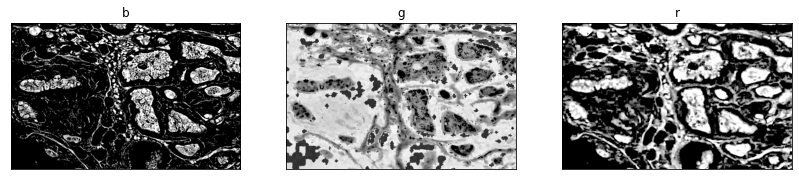

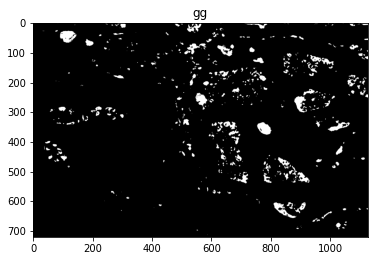

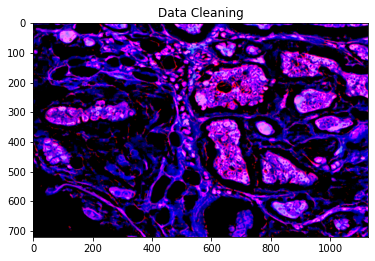

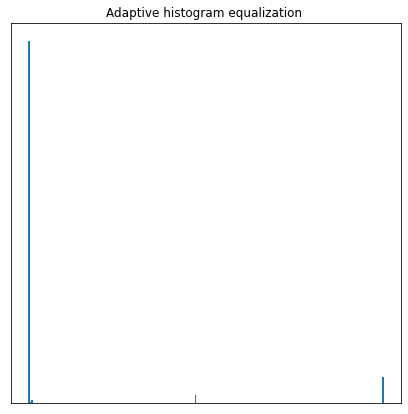

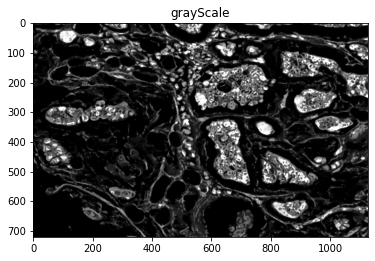

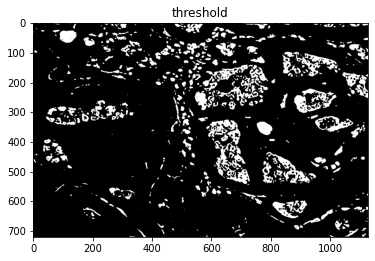

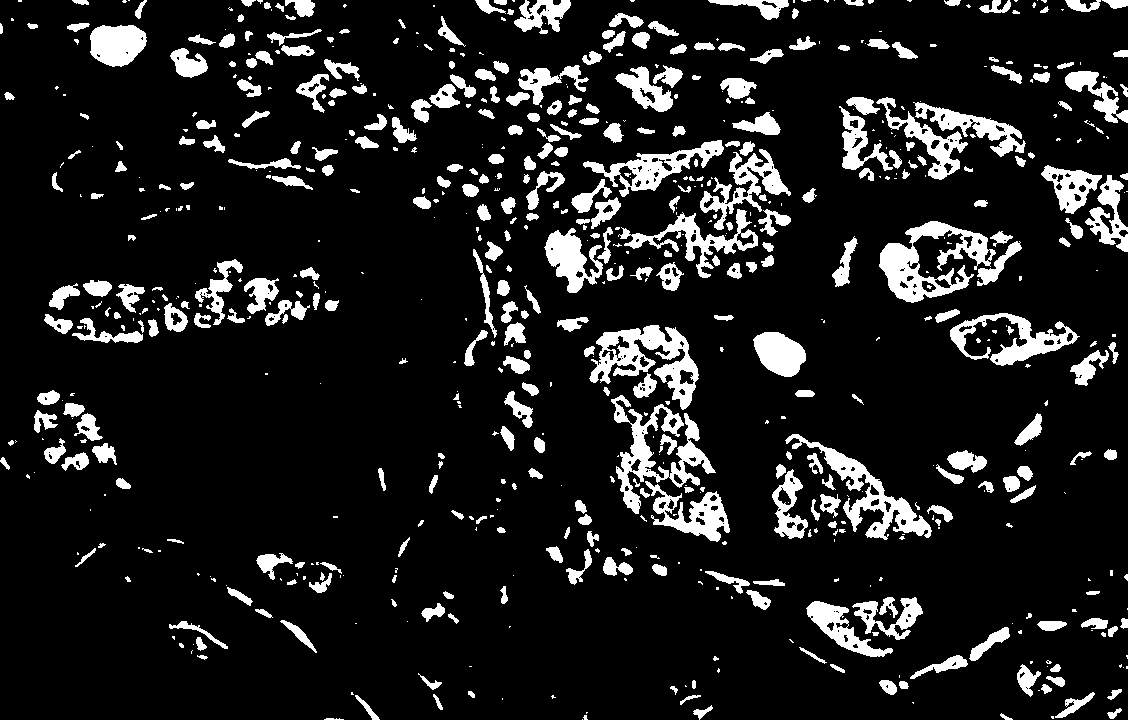

(720, 1128)

In [ ]:
from numpy.ma.core import shape
bb, gg, rr = cv2.split(dst)  # split on 3 different channels
plt.figure(figsize=(14, 14))
plt.subplot(231), plt.imshow(bb, cmap='gray')
plt.title('b'), plt.xticks([]), plt.yticks([])
plt.subplot(232), plt.imshow(gg, cmap='gray')
plt.title('g'), plt.xticks([]), plt.yticks([])
plt.subplot(233), plt.imshow(rr, cmap='gray')
plt.title('r'), plt.xticks([]), plt.yticks([])
plt.show()
ret1,gg = cv2.threshold(gg,0,120,cv2.THRESH_BINARY_INV)
plt.imshow(gg, cmap='gray'), plt.title('gg')
plt.show()
lab11 = cv2.merge((rr,gg,bb))
lab01 = cv2.merge((bb,gg,rr))
plt.imshow(lab01), plt.title('Data Cleaning')
plt.show()

output_path = '/content/drive/MyDrive/BreastCancer/Dataset/savee'
#cv2.imwrite(os.path.join(output_path, filename+'_pic' +'.jpg' ),lab11)
cv2.destroyAllWindows()
plt.figure(figsize=(7, 7))
plt.subplot(111), plt.hist(lab11.ravel(),256,[0,256])
plt.title('Adaptive histogram equalization '), plt.xticks([]), plt.yticks([])
plt.show()
grayScalee = cv2.cvtColor( lab01, cv2.COLOR_RGB2GRAY )
#cv2_imshow(grayScale)
plt.imshow(grayScalee, cmap='gray'), plt.title('grayScale')
plt.show()

ret1,threshold21 = cv2.threshold(grayScalee,77,255,cv2.THRESH_BINARY)
plt.imshow(threshold21, cmap='gray'), plt.title('threshold')
plt.show()
cv2_imshow(threshold21)
shape(threshold21)

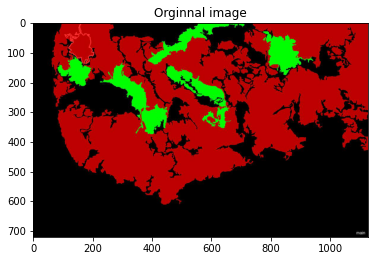

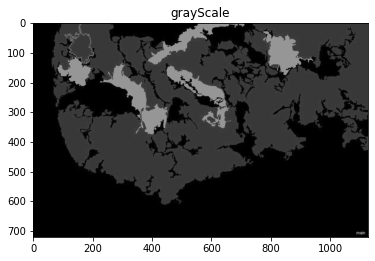

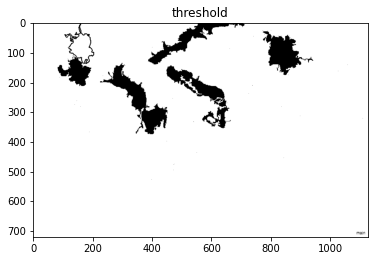

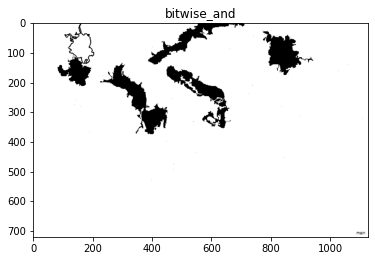

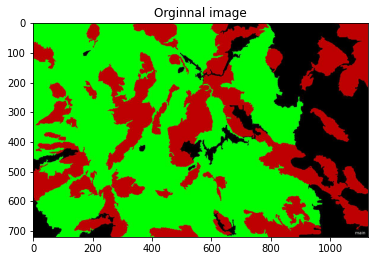

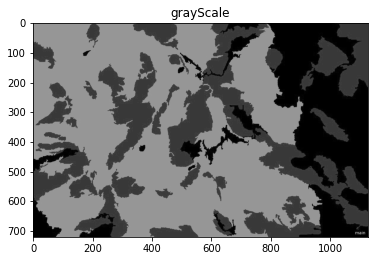

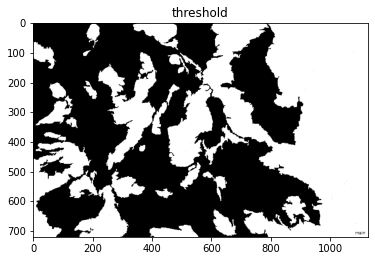

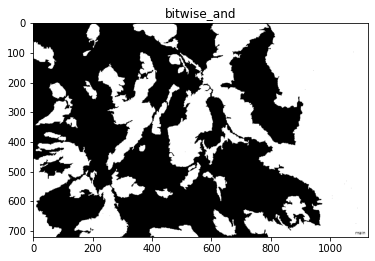

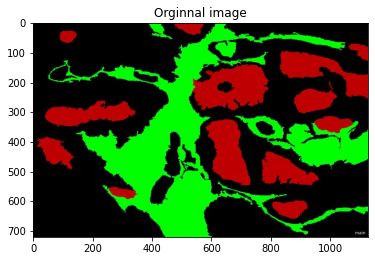

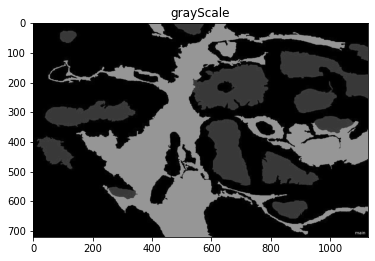

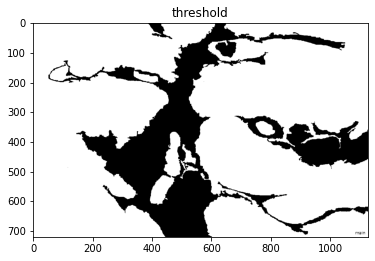

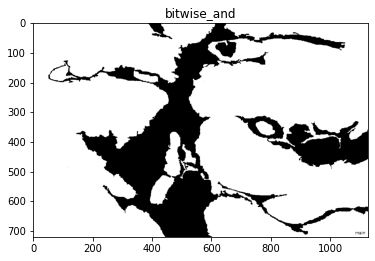

In [ ]:
for im in glob.glob('/content/drive/MyDrive/BreastCancer/Dataset/Dataset/Masks_Train/*.jpg'):

     img = mpimg.imread(im)
     plt.imshow(img, cmap='gray'), plt.title('Orginnal image')
     plt.show()

     grayScalee = cv2.cvtColor( img, cv2.COLOR_RGB2GRAY )
#cv2_imshow(grayScale)
     plt.imshow(grayScalee, cmap='gray'), plt.title('grayScale')
     plt.show()
     ret1,threshold21 = cv2.threshold(grayScalee,77,127,cv2.THRESH_BINARY_INV)
     plt.imshow(threshold21, cmap='gray'), plt.title('threshold')
     plt.show()
     resb = cv2.bitwise_and(img, img, mask= threshold21)
     plt.imshow(threshold21, cmap='gray'), plt.title('bitwise_and')
     plt.show()
     output_path = '/content/drive/MyDrive/BreastCancer/Dataset/Dataset'
     cv2.imwrite(os.path.join(output_path, filename+'_pic' +'.jpg' ),threshold21)
     cv2.destroyAllWindows()


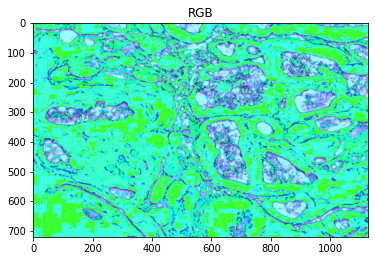

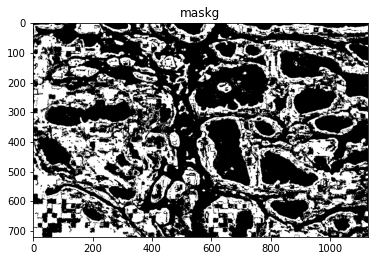

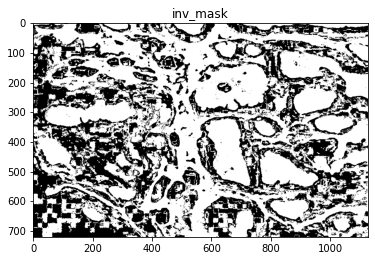

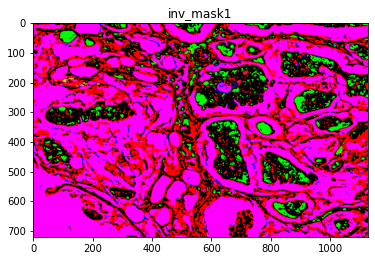

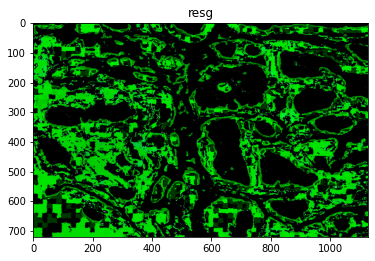

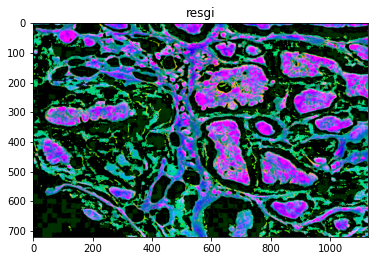

In [ ]:

#img = cv2.imread('bgrtohsv.png')
#تبدیل فضای رنگ bgr to hsv

hsv3 = cv2.cvtColor(Enhance_img,cv2.COLOR_BGR2HSV )
plt.imshow(hsv3), plt.title('RGB')
plt.show()

lower_blue = np.array([110,50,50])
upper_blue = np.array([120,255,255])

lower_green = np.array([50,50,50])
upper_green = np.array([60,255,255])

lower_red = np.array([0,50,50])
upper_red = np.array([0,255,255])


#آستانه گیری(cv2.inRange())
maskb = cv2.inRange(hsv3, lower_blue, upper_blue)
maskg = cv2.inRange(hsv3, lower_green, upper_green)
ret,inv_mask = cv2.threshold(maskg, 157, 255, cv2.THRESH_BINARY_INV)
ret,inv_mask1 = cv2.threshold(Enhance_img, 10, 255, cv2.THRESH_BINARY_INV)
maskr = cv2.inRange(hsv3, lower_red, upper_red)
# and تصویر اصلی با ماسک
#میشود (cv2.bitwise_and())
resb = cv2.bitwise_and(img3,img3, mask= maskb)
resg = cv2.bitwise_and(Enhance_img,Enhance_img, mask= maskg)
resgi = cv2.bitwise_and(Enhance_img,Enhance_img, mask= inv_mask)
resr = cv2.bitwise_and(img3,img3, mask= maskr)

#plt.imshow(img3), plt.title('img3')
#plt.show()
#plt.imshow(maskb, cmap='gray'), plt.title('maskb')
#plt.show()
plt.imshow(maskg, cmap='gray'), plt.title('maskg')
plt.show()
plt.imshow(inv_mask, cmap='gray'), plt.title('inv_mask')
plt.show()
plt.imshow(inv_mask1, cmap='gray'), plt.title('inv_mask1')
plt.show()
#plt.imshow(maskr, cmap='gray'), plt.title('maskr')
#plt.show()
#cv2_imshow(img3)
#cv2_imshow(maskb)
#cv2_imshow(maskg)
#cv2_imshow(maskr)

#plt.imshow(resb), plt.title('resb')
#plt.show()
plt.imshow(resg, cmap='gray'), plt.title('resg')
plt.show()
plt.imshow(resgi), plt.title('resgi')
plt.show()
#plt.imshow(resr), plt.title('resr')
#plt.show()

#cv2_imshow(resb)
#cv2_imshow(resg)
#cv2_imshow(resr)

cv2.waitKey()
cv2.destroyAllWindows()

##Data Preprocessing :Skin lesion segmentation

# Transformations

*   Dataloader object uses these tranformations when loading data.




In [ ]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
len(train_ds)

32097

##ِDiagram: Cross Entropy Loss

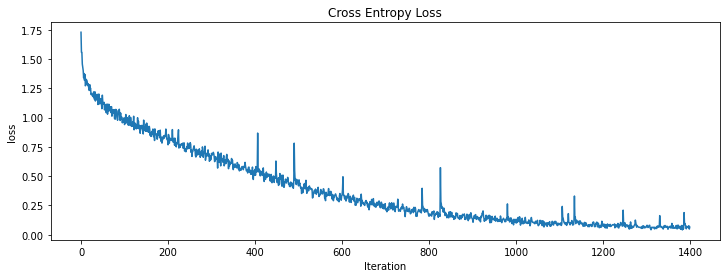

In [ ]:
plt.figure(figsize=(12, 4))
#plt.plot(losses)
plt.plot(loss_over_time)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss');

##ِDiagram: Train Accuracy

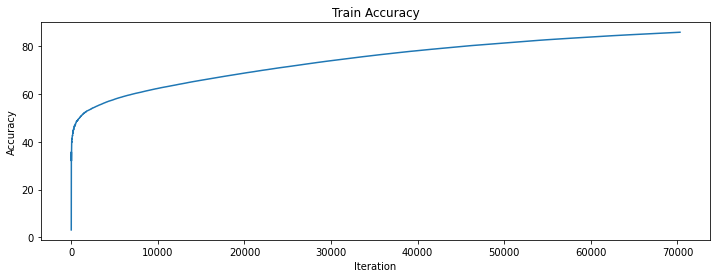

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(accuracy_total_train)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Train Accuracy');